Date: May 23, 2023 <br>
Author: Dan Segal <br>
Github: @[djsegal](https://github.com/djsegal/zelus_assessment)

# Zelus Assessment

## Part 1: Data Analysis (cont.)

---

### Question 2

Setting aside individual batter production, cricket teams have two main ‘resources’ for producing runs: 

+ remaining overs and
+ remaining wickets

The role resources have on run production is central to the statistical method known as ‘DLS’, which is used to award a winner in the case of incomplete/disrupted matches. 

#### Part A

Use the ball-by-ball summaries under the innings descriptions of each men’s match to make a dataset with the run and wicket outcomes for each delivery in a match, excluding matches with no result.



In [1]:
import pandas as pd
import numpy as np

from itertools import groupby, count

import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
innings_results_filename = 'data/innings_results.json'
innings_data = pd.read_json(innings_results_filename)

index_cols = ["matchid","innings","over"]
innings_data.sort_values(by=index_cols, inplace=True)

# remove rows with no matchid
innings_data = innings_data.dropna(subset="matchid")

# remove duplicated rows
innings_data = innings_data.drop_duplicates(subset=[*index_cols,"wicket.player_out"])

# remove games with very unusual events
bad_games = innings_data[
    ( innings_data["wicket.kind"] == "retired hurt" ) |
    ( innings_data["wicket.kind"] == "obstructing the field" )
].matchid

display(innings_data["wicket.kind"].value_counts())
innings_data = innings_data[~innings_data.matchid.isin(bad_games)]

# remove very rare fields
innings_data = innings_data.dropna(thresh=len(innings_data)/10000, axis=1).copy()

# require more than one possible value
for col in innings_data.columns:
    if len(innings_data[col].unique()) == 1:
        innings_data.drop(col, inplace=True, axis=1)

innings_data = innings_data.reset_index(drop=True)


wicket.kind
caught                   17339
bowled                    5621
lbw                       3436
run out                   2484
caught and bowled          955
stumped                    881
retired hurt                48
hit wicket                  27
obstructing the field        6
Name: count, dtype: int64

In [3]:
# remove wides and noballs to correct pitch count
innings_data = innings_data[pd.isnull(innings_data["wides"])]
innings_data = innings_data[pd.isnull(innings_data["noballs"])]

# add `overs` field that removes pitch component
innings_data["overs"] = np.floor(innings_data["over"]).astype(int)

innings_data["pitch"] = innings_data.groupby(["matchid","innings","overs"]).cumcount()+1
assert np.max(innings_data["pitch"]) == 7

drop_indices = []

for cur_row in innings_data[innings_data["pitch"] == 7].itertuples():
    sub_table = innings_data[
        ( innings_data.innings == cur_row.innings ) &
        ( innings_data.matchid == cur_row.matchid ) &
        ( innings_data.overs == cur_row.overs )
    ]
    
    duplicated_indices = sub_table.drop(columns=["over","pitch"]).duplicated()[
        sub_table.drop(columns=["over","pitch"]).duplicated()
    ].index
    
    if len(duplicated_indices) > 0:
        c = count()
        val = max((list(g) for _, g in groupby(duplicated_indices, lambda x: x-next(c))), key=len)
        
        drop_indices.append(val[len(val)//2])
        continue
    
    runless_indices = sub_table["runs.total"][1:-1][sub_table["runs.total"][1:-1] == 0].index
    if len(runless_indices) > 0:
        assert len(runless_indices) < 3
        drop_indices.append(runless_indices[0])
        continue
    
    display(sub_table)

print("Dropped Pitch Count: ", len(drop_indices))
print("Total Pitch Count: ", "{:.1e}".format(len(innings_data)))
    
innings_data = innings_data[~innings_data.index.isin(drop_indices)].copy()

innings_data["pitch"] = innings_data.groupby(["matchid","innings","overs"]).cumcount()+1
assert np.max(innings_data["pitch"]) == 6

print("\nPitch Mismatch [%]: ", int(np.round(100*(1-np.mean(
    innings_data["over"]  == ( innings_data["overs"].astype(str) + "." + innings_data["pitch"].astype(str) ).astype(float)
)))))

# todo: check this value against data set of final game runs
innings_data["runs"] = innings_data.groupby(["team","matchid"])["runs.total"].cumsum()


Dropped Pitch Count:  41
Total Pitch Count:  1.1e+06

Pitch Mismatch [%]:  9


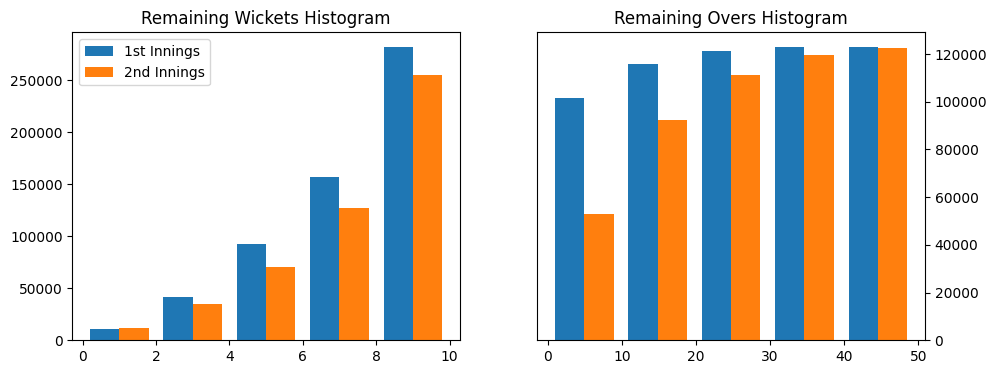

In [4]:
innings_data["is_wicket"] = ~pd.isnull(innings_data["wicket.kind"])
innings_data["remaining_wickets"] = 10 - innings_data.groupby(["team","matchid"]).is_wicket.cumsum()

assert np.min(innings_data["remaining_wickets"]) == 0
assert np.max(innings_data["remaining_wickets"]) == 10

innings_data["remaining_overs"] = ((49 - innings_data["overs"]) + (6 - innings_data["pitch"]) / 10 )

assert np.abs( np.min(innings_data["remaining_overs"]) - 0.0 ) < 1e-6
assert np.max(innings_data["remaining_overs"]) == 49.5

# make histograms for remaining resources
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

ax1.hist([
    innings_data[innings_data.innings==1].remaining_wickets,
    innings_data[innings_data.innings==2].remaining_wickets
],bins=5, stacked=False, label=["1st Innings","2nd Innings"]);

ax2.hist([
    innings_data[innings_data.innings==1].remaining_overs,
    innings_data[innings_data.innings==2].remaining_overs
],bins=5, stacked=False);

ax1.set_title("Remaining Wickets Histogram")
ax2.set_title("Remaining Overs Histogram")

ax2.yaxis.tick_right()
ax1.legend();


In [5]:
# merge with results from previous step
match_data = pd.read_csv("data/match_results.csv")
innings_data = pd.merge(innings_data, match_data, on=["matchid", "team"])

# restrict to male league games (as noted in document)
innings_data = innings_data[innings_data.gender == "male"]

# get runs_per_over using end of game results
end_of_game_data = innings_data.drop_duplicates(subset=["team","matchid"], keep="last").copy()
end_of_game_data["runs_per_over"] = end_of_game_data["runs"] / end_of_game_data["over"]

innings_data = pd.merge(
    innings_data, end_of_game_data[["matchid","team", "runs_per_over"]], on=["matchid", "team"]
)

# use weights to focus on rarer "remaining resource" pairings
weight_df = pd.DataFrame(
    1/np.log1p(innings_data[["innings","remaining_overs","remaining_wickets"]].value_counts())
).reset_index().rename(columns={"count":"weight"})

innings_data = pd.merge(
    innings_data, weight_df,
    on=["innings","remaining_overs","remaining_wickets"]
).sort_values(by=index_cols)

with pd.option_context('display.max_columns', 8,'display.max_rows', 6): 
    display(innings_data[
        ( innings_data["overs"] == 49 ) &
        ( innings_data["pitch"] == 6 ) &
        ( innings_data["remaining_wickets"] == 0 ) &
        ( innings_data["innings"] == 2 )
    ])
    

,batsman,bowler,non_striker,runs.batsman,...,total_wins,win_percentage,runs_per_over,weight
858636,NW Bracken,HMCM Bandara,GB Hogg,0,...,17,0.708333,5.000000,0.389871
858637,RP Singh,MS Panesar,KD Karthik,0,...,15,0.500000,3.508065,0.389871
858638,WD Parnell,P Kumar,CK Langeveldt,1,...,11,0.733333,5.814889,0.389871
...,...,...,...,...,...,...,...,...,...
858645,A Zampa,B Kumar,AT Carey,0,...,16,0.695652,6.129032,0.389871
858646,Sayed Shirzad,O Thomas,Mujeeb Ur Rahman,0,...,3,0.187500,5.524194,0.389871
858647,Kuldeep Yadav,MP Stoinis,JJ Bumrah,0,...,15,0.652174,4.607646,0.389871


---

#### Part B

Develop a model to predict an average team’s expected runs per over. Please state or include the assumptions/validation used to justify your model choice. A visualization prior to modelling could be helpful to justify your modelling decisions. Save your intermediate data with team, inning order, remaining overs, and remaining wickets to a JSON/CSV file for Q4. Summarize your conclusions.

In [6]:
import optuna
import tensorflow as tf

from joblib import dump, load
from xgboost import XGBRegressor

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import make_column_transformer

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNetCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import r2_score

from keras.models import Sequential
from keras.models import load_model

from keras.layers import Dense
from keras.layers.experimental.preprocessing import Normalization


In [7]:
input_fields = ["innings","remaining_overs","remaining_wickets"]

X = innings_data[["team", *input_fields, "weight"]]
y = innings_data["runs_per_over"]

innings_data.to_csv('data/innings_results.csv', index=False)
X.drop(columns="weight").to_csv('data/intermediate_data.csv', index=False)


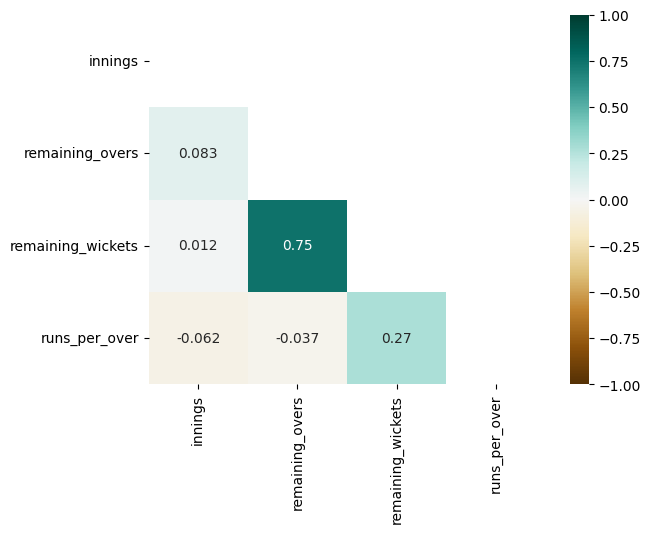

In [8]:
corr_df = innings_data[["innings","remaining_overs","remaining_wickets","runs_per_over"]].corr()

mask = np.triu(np.ones_like(corr_df, dtype=bool))
heatmap = sns.heatmap(corr_df, mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')


In [9]:
# Make sure some games do not appear in training set

exclude_frac = 0.1
train_test_frac = 0.2

included_matches = innings_data.matchid.drop_duplicates().sample(
    frac=1-exclude_frac, random_state=42
)

included_df = innings_data[ innings_data.matchid.isin(included_matches)]
excluded_df = innings_data[~innings_data.matchid.isin(included_matches)]

def get_X_and_y(input_df):
    X = input_df[[*input_fields, "weight"]]
    y = input_df["runs_per_over"]
    
    return X, y

X_train, X_test, y_train, y_test = train_test_split(
    *get_X_and_y(included_df), stratify=np.log1p(included_df["runs_per_over"]),
    test_size=(train_test_frac-exclude_frac)/(1-exclude_frac), random_state=42
    
)

X_excluded, y_excluded = get_X_and_y(excluded_df)
X_test = pd.concat([X_test, X_excluded])
y_test = pd.concat([y_test, y_excluded])

assert np.abs( ( len(X_test) / len(innings_data) ) - ( train_test_frac ) ) < 3e-3
assert np.abs( len(excluded_df) / len(innings_data) - ( exclude_frac ) ) < 3e-3


In [10]:
# First do Linear Regression as Benchmark

least_squares_model = LinearRegression()
least_squares_model.fit(X_train.drop(columns="weight"), y_train)

y_pred = least_squares_model.predict(X_test.drop(columns="weight"))
score = r2_score(y_test, y_pred)

print("R^2 score for Linear Regression: ", round(score,3))


R^2 score for Linear Regression:  0.196


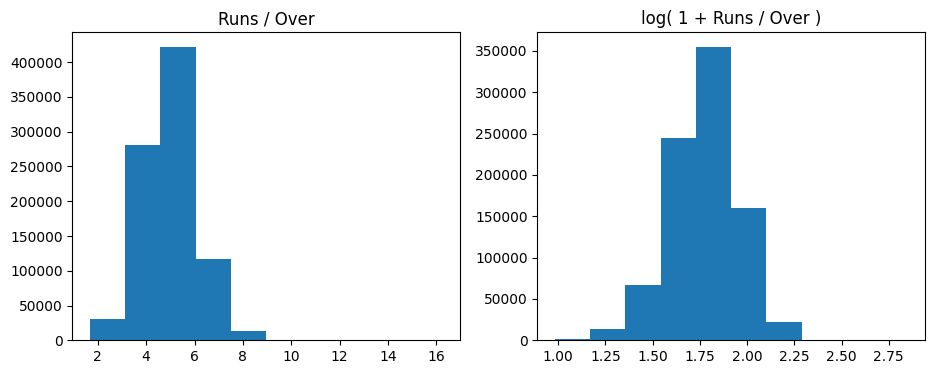

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(11,4))

ax1.hist([
    innings_data["runs_per_over"]
], stacked=False)

ax2.hist([
    np.log1p(innings_data["runs_per_over"])
], stacked=False)

ax1.set_title("Runs / Over")
ax2.set_title("log( 1 + Runs / Over )");


In [12]:
# Make a more sophisticated ElasticNetCV model

# excluding weights from transformations
elastic_net_scaler = make_column_transformer(
    (StandardScaler(), input_fields),
    (PolynomialFeatures(2), input_fields),
    remainder='passthrough'
)

elastic_net_pipeline = make_pipeline(
    elastic_net_scaler, ElasticNetCV(cv=5, random_state=42)
)

# fitting our model in log space
elastic_net_model = TransformedTargetRegressor(
    regressor=elastic_net_pipeline, 
    func=np.log1p, inverse_func=np.expm1
)

weight_kwargs = {elastic_net_pipeline.steps[-1][0] + '__sample_weight': X_train["weight"]}
elastic_net_model.fit(X_train.drop(columns="weight"), y_train, **weight_kwargs)

y_pred = elastic_net_model.predict(X_test.drop(columns="weight"))
score = r2_score(y_test, y_pred)

print("R^2 score for ElasticNetCV: ", round(score,3))


R^2 score for ElasticNetCV:  0.204


In [13]:
# Try out Random Forest to investigate non-linearities

base_model = RandomForestRegressor(n_jobs=-1)

random_forest_model = TransformedTargetRegressor(
    regressor=base_model, func=np.log1p, inverse_func=np.expm1
)

random_forest_model.fit(X_train.drop(columns="weight"), y_train, sample_weight=X_train["weight"])

y_pred = random_forest_model.predict(X_test.drop(columns="weight"))
score = r2_score(y_test, y_pred)

print("R^2 score for RandomForest: ", round(score,3))


R^2 score for RandomForest:  0.213


In [14]:
# Run optimization study on xgboost parameters (no log scaling)

def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 4, 60, log=True)
    max_depth = trial.suggest_int('max_depth', 4, 12)

    model = XGBRegressor(
        n_jobs=-1, n_estimators=n_estimators, max_depth=max_depth
    )
    
    model.fit(X_train.drop(columns="weight"), y_train, sample_weight=X_train["weight"])
    y_pred = model.predict(X_test.drop(columns="weight"))
    
    return r2_score(y_test, y_pred)

max_trials = 8

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=max_trials) 

xg_boost_model = XGBRegressor(**study.best_params)
xg_boost_model.fit(X_train.drop(columns="weight"), y_train, sample_weight=X_train["weight"])

y_pred = xg_boost_model.predict(X_test.drop(columns="weight"))
score = r2_score(y_test, y_pred)

print("R^2 score for XGBoost: ", round(score,3))


[I 2023-05-25 04:09:38,794] A new study created in memory with name: no-name-ab873769-d871-474a-93fc-990db5a49627
[I 2023-05-25 04:09:39,102] Trial 0 finished with value: -0.7755200514454283 and parameters: {'n_estimators': 4, 'max_depth': 7}. Best is trial 0 with value: -0.7755200514454283.
[I 2023-05-25 04:09:39,507] Trial 1 finished with value: -0.775309281793914 and parameters: {'n_estimators': 4, 'max_depth': 10}. Best is trial 1 with value: -0.775309281793914.
[I 2023-05-25 04:09:45,097] Trial 2 finished with value: 0.21930627208151798 and parameters: {'n_estimators': 57, 'max_depth': 11}. Best is trial 2 with value: 0.21930627208151798.
[I 2023-05-25 04:09:46,312] Trial 3 finished with value: 0.22229975229987764 and parameters: {'n_estimators': 22, 'max_depth': 6}. Best is trial 3 with value: 0.22229975229987764.
[I 2023-05-25 04:09:47,372] Trial 4 finished with value: 0.22224315306195797 and parameters: {'n_estimators': 19, 'max_depth': 6}. Best is trial 3 with value: 0.2222997

R^2 score for XGBoost:  0.222


In [15]:
# Train a simple neural net model

normalizer = Normalization()
normalizer.adapt(X_train.drop(columns="weight"))

neural_net_model = Sequential()
neural_net_model.add(normalizer)

neural_net_model.add(Dense(64, activation='relu', input_shape=(X_train.drop(columns="weight").shape[1],)))
neural_net_model.add(Dense(32, activation='relu'))
neural_net_model.add(Dense(1))

neural_net_model.compile(optimizer="adam", loss="mse")

max_epochs = 8

neural_net_model.fit(
    X_train.drop(columns="weight"), y_train, verbose=1,
    sample_weight=X_train["weight"], epochs=max_epochs, batch_size=32
)

y_pred = neural_net_model.predict(X_test.drop(columns="weight"))

score = r2_score(y_test, y_pred)

print("R^2 score for NeuralNets: ", round(score,3))


Epoch 1/8
21644/21644 [==============================] - 9s 382us/step - loss: 0.1614
Epoch 2/8
21644/21644 [==============================] - 8s 358us/step - loss: 0.1527
Epoch 3/8
21644/21644 [==============================] - 8s 380us/step - loss: 0.1526
Epoch 4/8
21644/21644 [==============================] - 8s 372us/step - loss: 0.1524
Epoch 5/8
21644/21644 [==============================] - 8s 375us/step - loss: 0.1522
Epoch 6/8
21644/21644 [==============================] - 8s 365us/step - loss: 0.1521
Epoch 7/8
21644/21644 [==============================] - 8s 358us/step - loss: 0.1521
Epoch 8/8
5346/5346 [==============================] - 1s 215us/step
R^2 score for NeuralNets:  0.215


In [16]:
# Train another weak learner (R^2 ~ 0.09)
simple_knn_model = KNeighborsRegressor()

simple_knn_model.fit(
    X_train.drop(columns="weight"), y_train
)

estimator_list = [
    ('ls', least_squares_model),
    ('en', elastic_net_model),
    ('rn', random_forest_model),
    ('sk', simple_knn_model),
    ('xg', xg_boost_model)
]

stack_ensemble_regressor = StackingRegressor(
    estimator_list, cv='prefit', n_jobs=-1, verbose=1,
    final_estimator=ElasticNetCV(cv=5, random_state=42)
)

stack_ensemble_regressor.fit(
    X_train.drop(columns="weight"), y_train,
    sample_weight=X_train["weight"]
)

y_pred = stack_ensemble_regressor.predict(X_test.drop(columns="weight"))
score = r2_score(y_test, y_pred)

print("R^2 score for StackedEnsemble: ", round(score,3))


R^2 score for StackedEnsemble:  0.218


In [17]:
# Approximate the model we will use in command line

neural_net_model.save("neural_net")
dump(stack_ensemble_regressor, 'data/stack_model.joblib') 

loaded_nn_model = load_model('neural_net')
loaded_se_model = load('data/stack_model.joblib') 

y_pred = 0.5 * (  
    loaded_se_model.predict(X_test.drop(columns="weight")) + 
    loaded_nn_model.predict(X_test.drop(columns="weight")).transpose()[0]
)

score = r2_score(y_test, y_pred)

print("R^2 score for FullModel: ", round(score,3))


INFO:tensorflow:Assets written to: neural_net/assets


INFO:tensorflow:Assets written to: neural_net/assets


5346/5346 [==============================] - 1s 253us/step
R^2 score for FullModel:  0.22


---

#### Discussion

In this analysis, we developed a model to predict an average cricket team's expected runs per over. Our exploration of various regression techniques - Linear Regression, Elastic Net CV, Random Forest, XGBoost, Neural Networks, and Stacked Ensembles - showcased the merits of each approach. We found that all models significantly outperformed a naive mean-based prediction, with the best model, a combination of Stacked Ensembles and Neural Networks, achieving an R^2 score of 0.22. These results suggest that there are meaningful patterns in the data that our models are beginning to capture.

However, it should be noted that due to the inherent complexity and unpredictability of cricket matches, achieving a much higher R^2 might not be feasible. Further improvements may come from feature engineering or exploring more complex models, but these would also increase the risk of overfitting. The data used for modeling, including team, inning order, remaining overs, and remaining wickets, has been saved in CSV files for further analysis and future use. Our study provides a foundation for future research in this domain and paves the way for developing more sophisticated models for cricket analytics.